# Intro
---
This is a project for practicing creating a convolutional neural network for detecting metastatic tissue in histopathologic scans of lymph node sections from the PatchCamelyon (PCam) dataset.

Link to the dataset: https://github.com/basveeling/pcam

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Commands to retrieve and unzip data

In [2]:
!cp "/content/drive/MyDrive/PatchCamelyon/data.zip" /content/

In [ ]:
!unzip /content/data.zip -d /content/PatchCamelyon

In [4]:
BASE="/content/PatchCamelyon"
!mkdir -p "$BASE/train/images" "$BASE/train/labels"
!mkdir -p "$BASE/valid/images" "$BASE/valid/labels"
!mkdir -p "$BASE/test/images" "$BASE/test/labels"

In [5]:
!BASE="/content/PatchCamelyon"; \
for split in train valid test; do \
    gunzip "$BASE/camelyonpatch_level_2_split_${split}_x.h5.gz" && mv "$BASE/camelyonpatch_level_2_split_${split}_x.h5" "$BASE/${split}/images/"; \
    gunzip "$BASE/camelyonpatch_level_2_split_${split}_y.h5.gz" && mv "$BASE/camelyonpatch_level_2_split_${split}_y.h5" "$BASE/${split}/labels/"; \
    mv "$BASE/camelyonpatch_level_2_split_${split}_meta.csv" "$BASE/${split}/"; \
done

In [ ]:
!pip install grad-cam

In [22]:
# Importing libraries
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [8]:
# Creating the dataset
class PatchCamelyonDataset(Dataset):
  def __init__(self, path_images, path_labels, transform=None):
    self.images_h5 = h5py.File(path_images, 'r')
    self.labels_h5 = h5py.File(path_labels, 'r')
    self.images = self.images_h5['x']
    self.labels = self.labels_h5['y']
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    if self.transform:
      image = self.transform(image)
    label = torch.tensor(self.labels[idx], dtype=torch.long).squeeze()
    return image, label

  def close(self):
    self.images_h5.close()
    self.labels_h5.close()

In [9]:
# Function to build the dataset
def build_dataset(split):
  # For building the test dataset, transforms are applied to help the model generalize
  if split == 'train':
    img_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
  else:
    img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
  base_images = f'/content/PatchCamelyon/{split}/images/camelyonpatch_level_2_split_{split}_x.h5'
  base_labels = f'/content/PatchCamelyon/{split}/labels/camelyonpatch_level_2_split_{split}_y.h5'
  return PatchCamelyonDataset(base_images, base_labels, img_transform)

# Creating the train, validation, and test dataloaders
train_dataset = build_dataset('train')
validation_dataset = build_dataset('valid')
test_dataset = build_dataset('test')

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Creating the CNN
class PatchCamelyonCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn_stack = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(16 * 24 * 24, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 2)
    )

  def forward(self, x):
    x = self.cnn_stack(x)
    x = self.fc(x)
    return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = PatchCamelyonCNN()
model.to(device)

In [12]:
# Setting up hyperparameters, loss function, and optimizer
learning_rate = 1e-3
epochs = 7

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# Training and validation loop
train_losses = []
validation_losses = []
for epoch in range(epochs):
  train_loss = 0
  validation_loss = 0
  model.train()

  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad():
    for X, y in validation_dataloader:
      X, y = X.to(device), y.to(device)

      pred = model(X)
      loss = loss_fn(pred, y)
      validation_loss += loss.item()

  train_losses.append(train_loss / len(train_dataloader))
  validation_losses.append(validation_loss / len(validation_dataloader))
  print(f'Epoch {epoch + 1} | Train Loss: {train_losses[-1]:.4f} | Validation Loss: {validation_losses[-1]:.4f}')

Epoch 1 | Train Loss: 0.3783 | Validation Loss: 0.4334
Epoch 2 | Train Loss: 0.3219 | Validation Loss: 0.3995
Epoch 3 | Train Loss: 0.2957 | Validation Loss: 0.3601
Epoch 4 | Train Loss: 0.2812 | Validation Loss: 0.3581
Epoch 5 | Train Loss: 0.2695 | Validation Loss: 0.3990
Epoch 6 | Train Loss: 0.2619 | Validation Loss: 0.3794
Epoch 7 | Train Loss: 0.2559 | Validation Loss: 0.3360


Code for saving and loading the model and recorded losses

In [17]:
torch.save(model.state_dict(), '/content/drive/MyDrive/PatchCamelyon/cnn.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/PatchCamelyon/cnn.pth'))

In [18]:
with open('/content/drive/MyDrive/PatchCamelyon/train_losses.txt', 'w') as f:
  for loss in train_losses:
    f.write(f'{loss}\n')

with open('/content/drive/MyDrive/PatchCamelyon/validation_losses.txt', 'w') as f:
  for loss in validation_losses:
    f.write(f'{loss}\n')

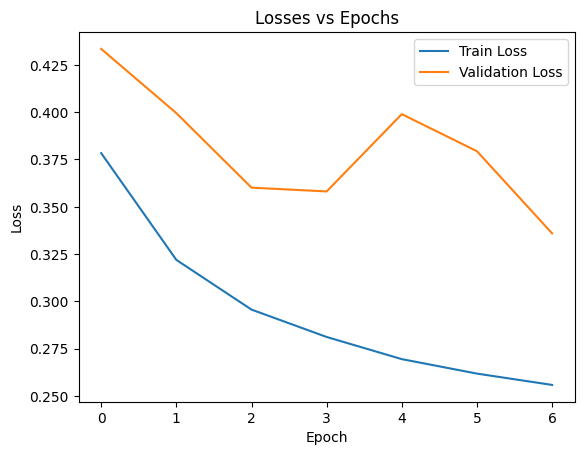

In [16]:
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses vs Epochs')
plt.legend()
plt.show()

In [20]:
# Testing loop
model.eval()
# Keeping track of class based accuracy and overall accuracy
class_total = [0, 0]
class_correct = [0, 0]
overall_total = 0
overall_correct = 0
# Keeping track of individual predictions and labels for use in confusion matrix and classification report
all_preds = []
all_labels = []

with torch.no_grad():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    outputs = model(X)

    _, predictions = torch.max(outputs, 1)
    overall_total += y.size(0)
    overall_correct += (predictions == y).sum().item()
    all_preds.extend(predictions.cpu().numpy())
    all_labels.extend(y.cpu().numpy())

    for label, prediction in zip(y, predictions):
      if label == prediction:
        class_correct[label.item()] += 1
      class_total[label.item()] += 1

class_names = ["No Center Tumor Patch", "Center Tumor Patch"]

for class_idx in range(len(class_names)):
  total = class_total[class_idx]
  accuracy = 100 * float(class_correct[class_idx]) / total
  print(f'Accuracy of {class_names[class_idx]}: {accuracy:.2f} %')

accuracy = 100 * float(overall_correct) / overall_total
print(f'Overall Accuracy of the network on test: {accuracy:.2f} %')

Accuracy of No Center Tumor Patch: 86.43 %
Accuracy of Center Tumor Patch: 80.45 %
Overall Accuracy of the network on test: 83.44 %


                       precision    recall  f1-score   support

No Center Tumor Patch       0.82      0.86      0.84     16391
   Center Tumor Patch       0.86      0.80      0.83     16377

             accuracy                           0.83     32768
            macro avg       0.84      0.83      0.83     32768
         weighted avg       0.84      0.83      0.83     32768



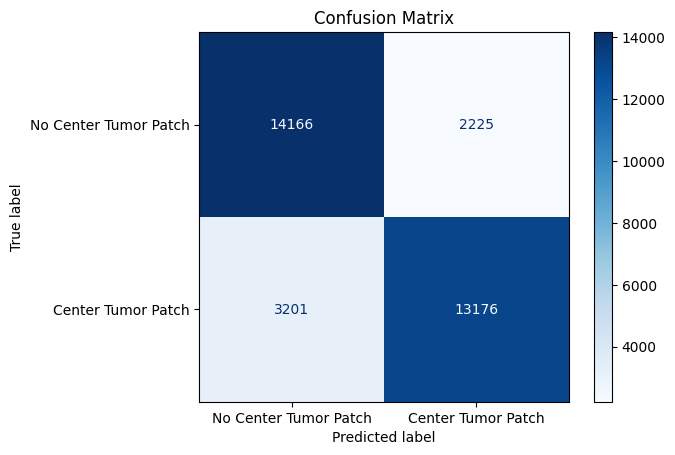

In [23]:
# Printing classification report and confusion matrix
print(classification_report(all_labels, all_preds, target_names=class_names))
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

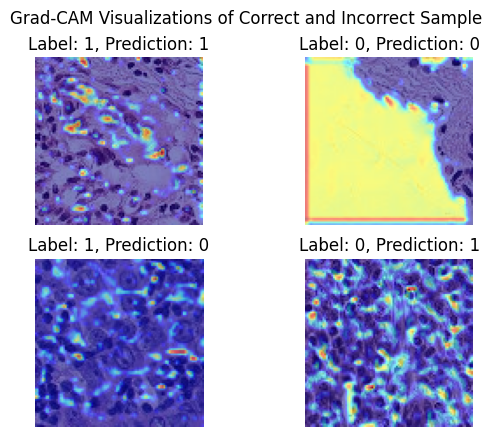

In [27]:
model.eval()
# Finding samples of an incorrect and correct prediction to apply Grad-CAM to
correct_sample_with_tumor = None
correct_sample_without_tumor = None
incorrect_sample_with_tumor = None
incorrect_sample_without_tumor = None

with torch.no_grad():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    outputs = model(X)

    _, predictions = torch.max(outputs, 1)

    for img, label, prediction in zip(X, y, predictions):
      if label == prediction and label == 1 and correct_sample_with_tumor is None:
        correct_sample_with_tumor = (img, label.item(), prediction.item())
      elif label == prediction and label == 0 and correct_sample_without_tumor is None:
        correct_sample_without_tumor = (img, label.item(), prediction.item())
      elif label != prediction and label == 1 and incorrect_sample_with_tumor is None:
        incorrect_sample_with_tumor = (img, label.item(), prediction.item())
      elif label != prediction and label == 0 and incorrect_sample_without_tumor is None:
        incorrect_sample_without_tumor = (img, label.item(), prediction.item())
      if (correct_sample_with_tumor and correct_sample_without_tumor
          and incorrect_sample_with_tumor and incorrect_sample_without_tumor):
        break

    if (correct_sample_with_tumor and correct_sample_without_tumor
        and incorrect_sample_with_tumor and incorrect_sample_without_tumor):
      break

# Function for visualizing Grad-CAM on a given image
def gradcam_visualization(img, label, pred, ax):
  input_tensor = img.unsqueeze(0)
  targets = [ClassifierOutputTarget(pred)]

  rgb_image = img.permute(1, 2, 0).cpu().numpy()
  rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

  with GradCAM(model=model, target_layers=[model.cnn_stack[5]]) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

  ax.imshow(visualization)
  ax.set_title(f'Label: {label}, Prediction: {pred}')
  ax.axis('off')

# Plotting Grad-CAM Visualizations
fig, axs = plt.subplots(2, 2)
fig.suptitle('Grad-CAM Visualizations of Correct and Incorrect Sample')

gradcam_visualization(*correct_sample_with_tumor, axs[0, 0])
gradcam_visualization(*correct_sample_without_tumor, axs[0, 1])
gradcam_visualization(*incorrect_sample_with_tumor, axs[1, 0])
gradcam_visualization(*incorrect_sample_without_tumor, axs[1, 1])

plt.show()

In [28]:
# Closing datasets
train_dataset.close()
validation_dataset.close()
test_dataset.close()